<h1 style="text-align:center; color:green; font-size:48px;">
OEMOF TUTORIAL
</h1>

### Support functions

In [61]:
# Levelized Cost of Heat

def LCOH(invest_cost, operation_cost, heat_produced, revenue=0, i=0.05, n=20):
    pvf = ((1 + i) ** n - 1) / ((1 + i) ** n * i)

    return (invest_cost + pvf * (operation_cost - revenue)) / (
        pvf * heat_produced
    )
    
# Equivalent Periodic Cost

def epc(invest_cost, i=0.05, n=20):
    af = (i * (1 + i) ** n) / ((1 + i) ** n - 1)

    return invest_cost * af

# Import libraries

In [62]:
import os
import warnings
import logging
import pandas as pd
import matplotlib.pyplot as plt
from oemof.solph import (Bus, EnergySystem, Flow, Model, create_time_index, processing)
from oemof.solph.components import (Sink, Source, Converter, GenericStorage)
from oemof.solph import EnergySystem
from oemof.solph import views
import oemof.solph as solph

# Example

<img src="Example_OEMOF.png" width="40%">

## 1.1 Create the energy system

In [ ]:
import os
import warnings
import logging
import pandas as pd
import matplotlib.pyplot as plt
from oemof.solph import (Bus, EnergySystem, Flow, Model, create_time_index, processing, NonConvex)
from oemof.solph.components import (Sink, Source, Converter, GenericStorage)
from oemof.solph import EnergySystem
from oemof.solph import views
import oemof.solph as solph

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# read the input data file
filename = r"STEP_3/inputs/data.csv"
data = pd.read_csv(filename, sep=";")

# --- Unit Conversion: kWh -> MWh ---
# The thermal demand in the CSV is in kWh, but other parameters (prices) are EUR/MWh.
# We convert demand to MWh to maintain consistency.
data["thermal_demand"] = data["thermal_demand"] / 1000

filename2 = r"STEP_3/inputs/irradiance_riga.csv"
irradiance_data = pd.read_csv(filename2, sep=";")
irradiance_data = irradiance_data.fillna(0)

# specifying the solver
solver = "cbc"
solver_verbose = False

# Create energy system
datetimeindex = create_time_index(2022, number=len(data))
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=False)

# --- Step 2: Buses, Sources, Sinks (Single Thermal Bus) ---

# Buses
electrical_bus = Bus(label="electrical_bus")
thermal_bus = Bus(label="thermal_bus")
gas_bus = Bus(label="gas_bus")
biomass_bus = Bus(label="biomass_bus") # New Biomass Bus
waste_heat_bus = Bus(label="waste_heat_bus") # New Waste Heat Bus
ambient_heat_bus = Bus(label="ambient_heat_bus") # for solar collector

energysystem.add(electrical_bus, thermal_bus, gas_bus, biomass_bus, waste_heat_bus, ambient_heat_bus)

# Excess electricity sink
energysystem.add(
    Sink(
        label="excess_electricity",
        inputs={electrical_bus: Flow(variable_costs=data["electricity_price"] * -1)}
    )
)

# Gas source with cost
energysystem.add(
    Source(label="natural_gas",outputs={gas_bus: Flow(variable_costs=(data["gas_price"] + data["co2_price"]))}) # Prices are EUR/MWh
                )

## Biomass source (Unlimited supply)
# Cost is fixed per unit of heat produced by CHP2, so we set source cost to 0 here.
energysystem.add(
    Source(label="biomass_source", outputs={biomass_bus: Flow(variable_costs=0)})
)

# Waste Heat Source (from data)
data["waste_heat"] = data["waste_heat"]

max_waste_heat = data["waste_heat"].max()
if max_waste_heat > 0:
    waste_heat_profile = data["waste_heat"] / max_waste_heat
else:
    waste_heat_profile = [0] * len(data)
    max_waste_heat = 0

energysystem.add(
    Source(
        label="waste_heat_source", 
        outputs={waste_heat_bus: Flow(max=waste_heat_profile, nominal_value=max_waste_heat)}
    )
)

# Grid electricity source
energysystem.add(
    Source(label="electricity_grid", outputs={electrical_bus: Flow(variable_costs=data["electricity_price"])})
)

# Ambient Heat source (Input to Solar Collector)
energysystem.add(
    Source(label="ambient_heat", outputs={ambient_heat_bus: Flow(variable_costs=0)})
)

# Thermal demand sink
max_demand = data["thermal_demand"].max()
demand_fix = data["thermal_demand"] / max_demand

print(f"Peak Thermal Demand: {max_demand:.2f} MWh")

energysystem.add(
    Sink(
        label="thermal_demand",
        inputs={thermal_bus: Flow(
            nominal_value=max_demand,
            fix=demand_fix
        )},
    )
)

# **Thermal storage is NOT included (as per Step 3 requirement).**
# Shortage Source (to prevent infeasibility)
energysystem.add(
    Source(
        label="thermal_shortage",
        outputs={thermal_bus: Flow(variable_costs=100000)} # High cost to discourage use
    )
)


# --- Step 3: Heat Producers (5 Total + Solar) ---

# Component Sizing Strategy:
# Peak Demand is approx 8-9 MWh (based on 8000+ kWh).
# CHP1 (Gas): ~50% of peak -> 4.5 MW_th
# CHP2 (Biomass): ~40% of peak -> 3.5 MW_th
# Gas Boiler: ~100% of peak (backup) -> 9 MW_th
# Heat Pump: ~20% of peak -> 1.8 MW_th
# Solar: ~10% contribution -> 1 MW_th (nominal)

# 1. Combined heat and power plant (CHP 1) - fuel 1 (Gas)
# NonConvex parameters added.
energysystem.add(
    Converter(
        label="chp_1", 
        inputs={gas_bus: Flow()},
        outputs={
            electrical_bus: Flow(variable_costs=5), # O&M cost
            thermal_bus: Flow(
                nominal_value=4.5, 
                nonconvex=NonConvex(
                    minimum_uptime=5, 
                    minimum_downtime=3, 
                    startup_costs=50, 
                    shutdown_costs=10,
                    initial_status=0
                )
            )
        },
        conversion_factors={electrical_bus: 0.421, thermal_bus: 0.474}
    )
)

# 2. Combined heat and power plant (CHP 2) - fuel 2 (Biomass)
# Uses unlimited biomass. Fixed cost per unit of heat.
energysystem.add(
    Converter(
        label="chp_2",
        inputs={biomass_bus: Flow()}, 
        outputs={
            electrical_bus: Flow(variable_costs=5),
            thermal_bus: Flow(
                nominal_value=3.5,
                variable_costs=20, # Fixed cost per unit of heat
                nonconvex=NonConvex(
                    minimum_uptime=10, 
                    minimum_downtime=5, 
                    startup_costs=100, 
                    shutdown_costs=20,
                    initial_status=0
                )
            ) 
        },
        conversion_factors={electrical_bus: 0.421, thermal_bus: 0.474}
    )
)

# 3. Gas Boiler 1
# Backup/Peaking unit.
energysystem.add(
    Converter(
        label="gas_boiler_1",
        inputs={gas_bus: Flow()},
        outputs={
            thermal_bus: Flow(
                nominal_value=9,
                nonconvex=NonConvex(
                    minimum_uptime=2, 
                    minimum_downtime=2, 
                    startup_costs=20, 
                    shutdown_costs=5,
                    initial_status=0
                )
            )
        },
        conversion_factors={thermal_bus: 0.95}
    )
)

# 4. Heat Pump (MODELED AS A CONVERTER)  - waste heat source
COP = 3.0
energysystem.add(
    Converter(
        label="heat_pump",
        inputs={
            electrical_bus: Flow(), 
            waste_heat_bus: Flow()
        }, 
        outputs={thermal_bus: Flow(nominal_value=1.8)},                     
        conversion_factors={
            thermal_bus: COP, 
            waste_heat_bus: COP - 1 
        }
    )
)

# 5. Solar Thermal Collector 
solar_thermal_conversion_factor = 0.5
energysystem.add(
    Converter(
        label="solar_collector",
        inputs={ambient_heat_bus: Flow()},
        outputs={thermal_bus: Flow(nominal_value=1.0)}, # Nominal value scaling
        conversion_factors={
            # The conversion factor is the time-series irradiance data
            thermal_bus: solar_thermal_conversion_factor * irradiance_data["DNI"]
        },
    )
)

# --- Step 4: Optimization and Results ---

print("Solving Optimization Model...")
model = Model(energysystem)

# Solve the optimization problem
try:
    model.solve(solver=solver, cmdline_options={"mipgap": 0.005}, solve_kwargs={"tee": solver_verbose})
    print("\nOptimization Complete.")
    
    # --- Results Summary ---
    print(f"Total Objective Value (Minimised System Costs): {model.objective():,.2f} EUR")
    results = processing.results(model)
    data_flow = processing.convert_keys_to_strings(results)

    print("\n### Heat Producer Output Summary (Total Flow to thermal_bus)")
    producer_labels = ["chp_1", "chp_2", "gas_boiler_1", "heat_pump", "solar_collector", "thermal_shortage"]
    summary_data = {}

    for label in producer_labels:
        # Correctly construct tuple key
        flow_key = (label, "thermal_bus")
        
        if flow_key in data_flow and 'sequences' in data_flow[flow_key] and 'flow' in data_flow[flow_key]['sequences']:
            flow_sum = data_flow[flow_key]['sequences']['flow'].sum()
            summary_data[label] = flow_sum
        else:
            summary_data[label] = 0.0 

    # Display results
    for producer, flow in sorted(summary_data.items(), key=lambda item: item[1], reverse=True):
        print(f"- {producer.replace('_', ' ').title():<18}: {flow:,.2f} MWh")

except Exception as e:
    print(f"\nOptimization Failed. Check the solver installation or data integrity. Error: {e}")


Peak Thermal Demand: 9.89 MWh
Solving Optimization Model...


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Optimization Complete.
Total Objective Value (Minimised System Costs): 7,251,383,025.03 EUR

### Heat Producer Output Summary (Total Flow to thermal_bus)
- Chp 2             : 23,995.73 MWh
- Heat Pump         : 7,765.34 MWh
- Gas Boiler 1      : 3,410.97 MWh
- Solar Collector   : 1,118.92 MWh
- Chp 1             : 191.85 MWh
- Thermal Shortage  : 7.25 MWh


## 1.2 Build and solve model

In [64]:
model = Model(energysystem)


logging.info("Solving the optimization problem.")
model.solve(
    solver='cbc',
    solve_kwargs={"tee": True},
    cmdline_options={"ratioGap": "0.02"}
)

'''
This returns a dictionary containing time series and scalar results for all components (buses, converters, sources, etc.).
Or view results for a specific node (for example, a bus).
'''

# Process results
energysystem.results["main"] = processing.results(model)
energysystem.results["meta"] = processing.meta_results(model)

# Save results to file
output_file = os.path.join(os.getcwd(), "STEP_3/outputs/results.oemof")

energysystem.dump(os.getcwd(), "STEP_3/outputs/results.oemof")

logging.info("Results have been dumped.")

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug  2 2025 

command line - /opt/anaconda3/envs/env_P2/bin/cbc -ratioGap 0.02 -printingOptions all -import /var/folders/48/nvz0qnqd5zd_kdw85vnnhrl40000gn/T/tmpzv2fmhhw.pyomo.lp -stat=1 -solve -solu /var/folders/48/nvz0qnqd5zd_kdw85vnnhrl40000gn/T/tmpzv2fmhhw.pyomo.soln (default strategy 1)
ratioGap was changed from 0 to 0.02
Option for printingOptions changed from normal to all
Presolve 148799 (-157769) rows, 139954 (-140356) columns and 586249 (-300900) elements
Statistics for presolved model
Original problem has 78830 integers (78830 of which binary)
Presolved problem has 78807 integers (78807 of which binary)
==== 34976 zero objective 13158 different
==== absolute objective values 7009 different
==== for integers 26270 zero objective 6 different
26270 variables have objective of 0
8757 variables have objective of 5
8756 variables have objective of 10
17512 variables have objective of 20
8757 variables have objective of 5

## 1.3 Results

In [65]:
energysystem.results

results = energysystem.results["main"]

# get all variables of a specific component/bus
thermal_bus_node = views.node(results, "thermal_bus")
storage = views.node(results, "storage")

### Analyse thermal node

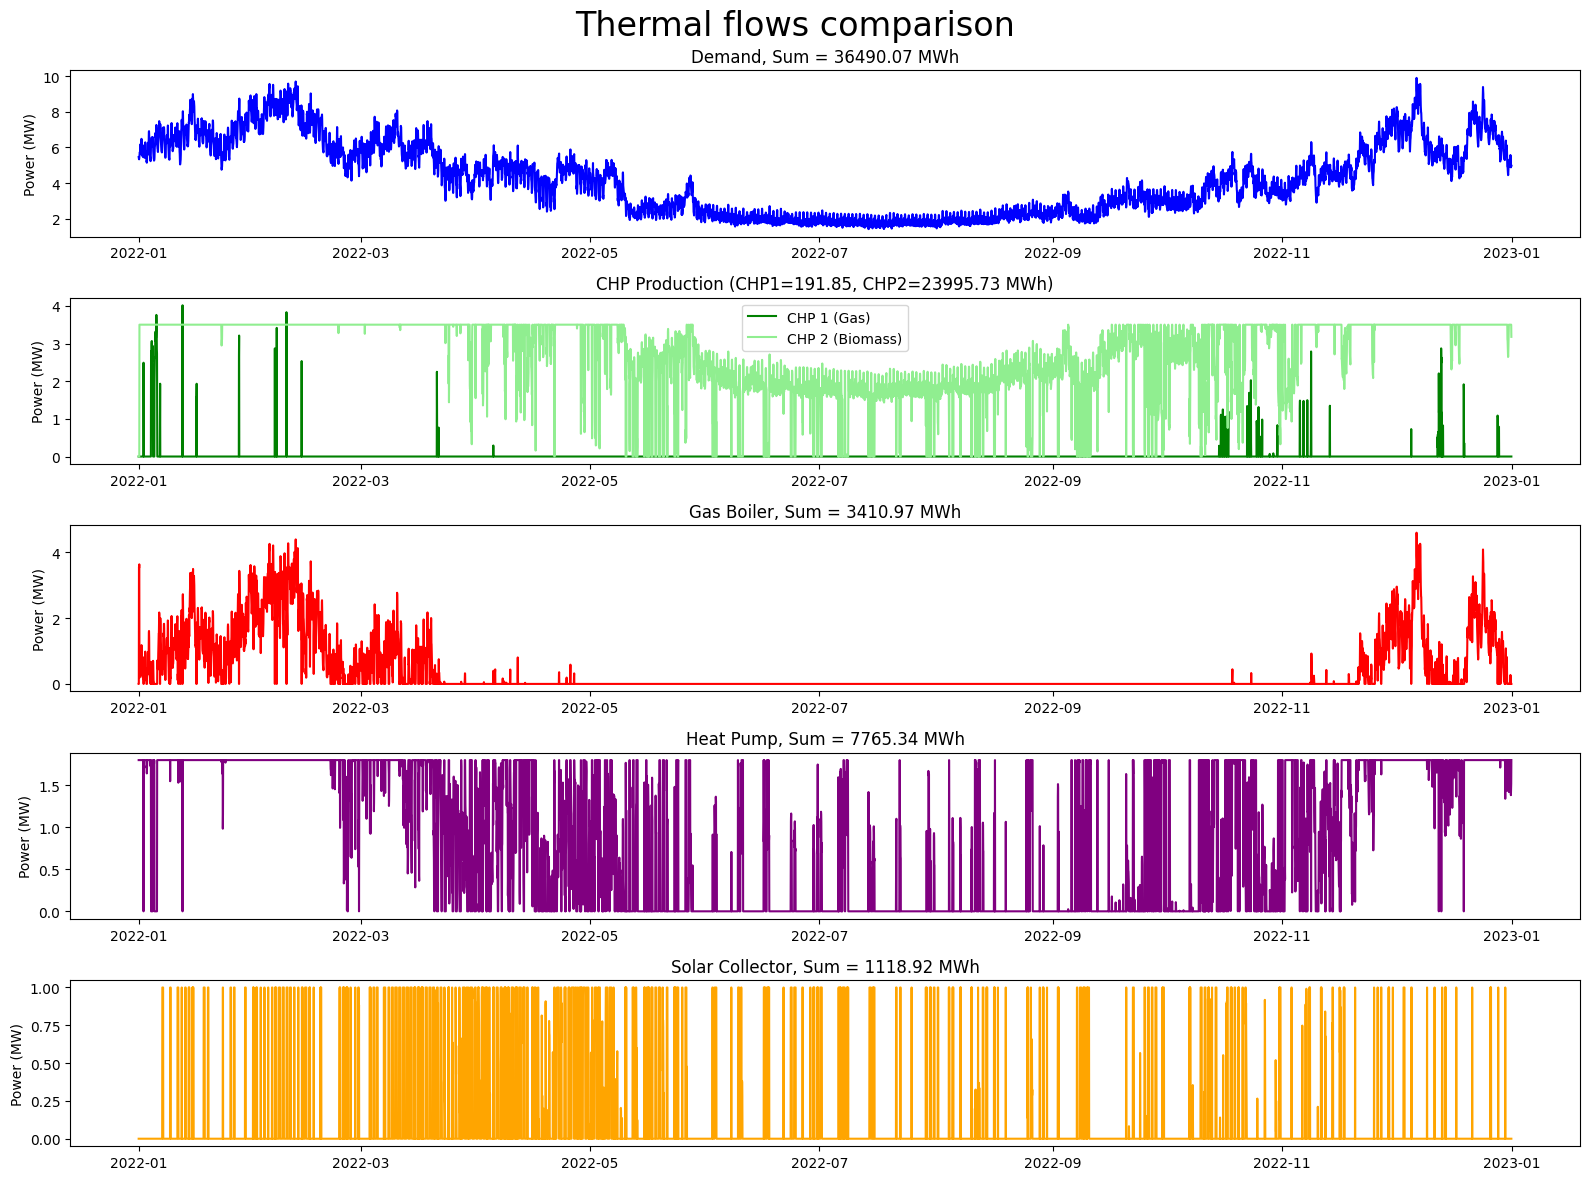

In [66]:

Sum_th_demand = thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand'), 'flow')].sum()
Sum_th_prod_chp1 = thermal_bus_node["sequences"][(('chp_1', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_chp2 = thermal_bus_node["sequences"][(('chp_2', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_boiler = thermal_bus_node["sequences"][(('gas_boiler_1', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_hp = thermal_bus_node["sequences"][(('heat_pump', 'thermal_bus'), 'flow')].sum()
Sum_th_prod_sc = thermal_bus_node["sequences"][(('solar_collector', 'thermal_bus'), 'flow')].sum()

fig, axs = plt.subplots(5, figsize=(16, 12)) 
fig.suptitle('Thermal flows comparison', fontsize=24)

# 1. Demand
axs[0].plot(thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand'), 'flow')], 'blue')
axs[0].set_title(f'Demand, Sum = {Sum_th_demand:.2f} MWh')
axs[0].set_ylabel('Power (MW)')

# 2. CHPs
axs[1].plot(thermal_bus_node["sequences"][(('chp_1', 'thermal_bus'), 'flow')], 'green', label='CHP 1 (Gas)')
axs[1].plot(thermal_bus_node["sequences"][(('chp_2', 'thermal_bus'), 'flow')], 'lightgreen', label='CHP 2 (Biomass)')
axs[1].set_title(f'CHP Production (CHP1={Sum_th_prod_chp1:.2f}, CHP2={Sum_th_prod_chp2:.2f} MWh)')
axs[1].legend()
axs[1].set_ylabel('Power (MW)')

# 3. Gas Boiler
axs[2].plot(thermal_bus_node["sequences"][(('gas_boiler_1', 'thermal_bus'), 'flow')], 'red')
axs[2].set_title(f'Gas Boiler, Sum = {Sum_th_prod_boiler:.2f} MWh')
axs[2].set_ylabel('Power (MW)')

# 4. Heat Pump
axs[3].plot(thermal_bus_node["sequences"][(('heat_pump', 'thermal_bus'), 'flow')], 'purple')
axs[3].set_title(f'Heat Pump, Sum = {Sum_th_prod_hp:.2f} MWh')
axs[3].set_ylabel('Power (MW)')

# 5. Solar Collector
axs[4].plot(thermal_bus_node["sequences"][(('solar_collector', 'thermal_bus'), 'flow')], 'orange')
axs[4].set_title(f'Solar Collector, Sum = {Sum_th_prod_sc:.2f} MWh')
axs[4].set_ylabel('Power (MW)')

plt.tight_layout()
plt.show()

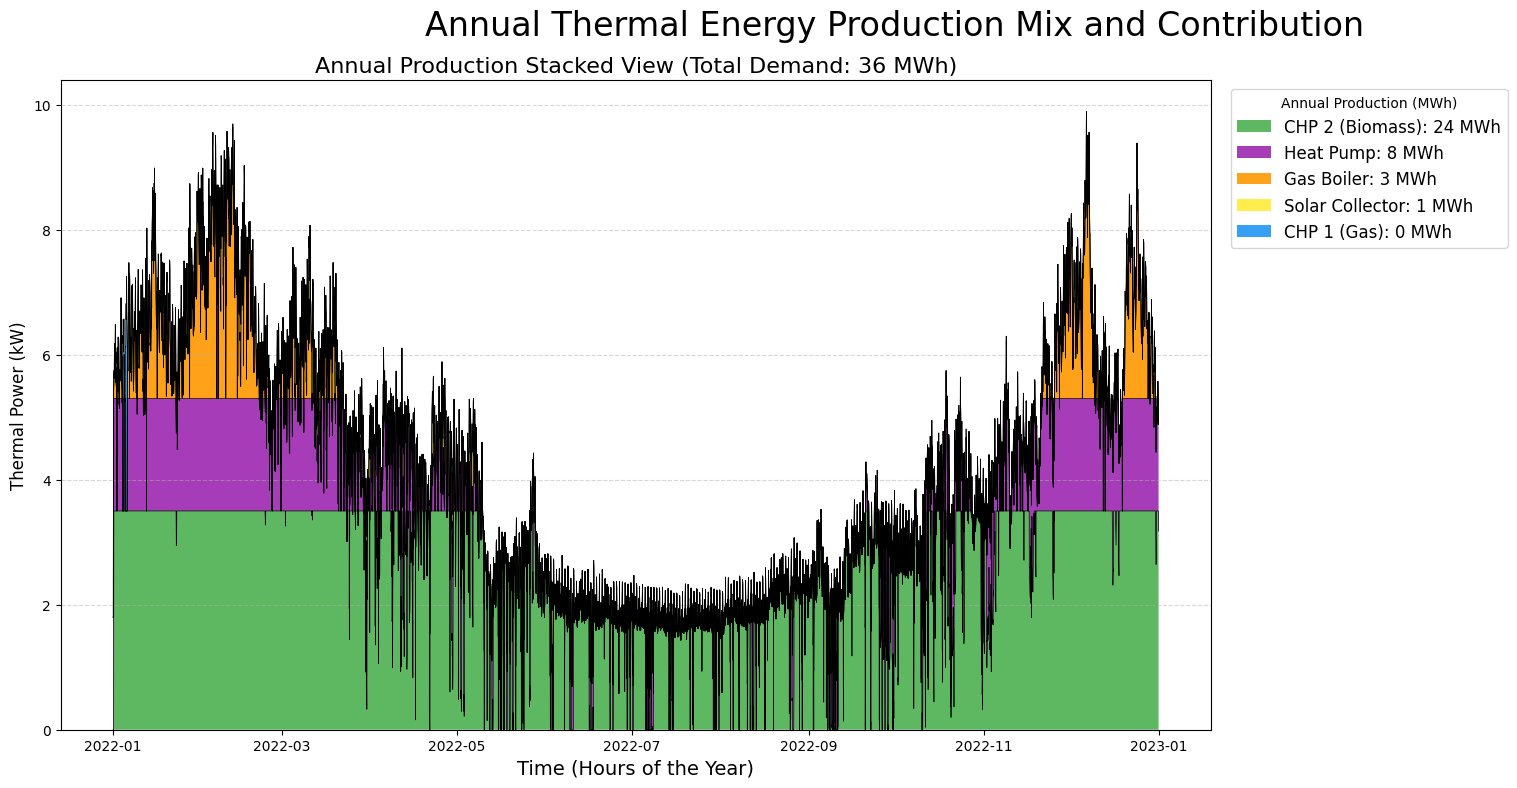

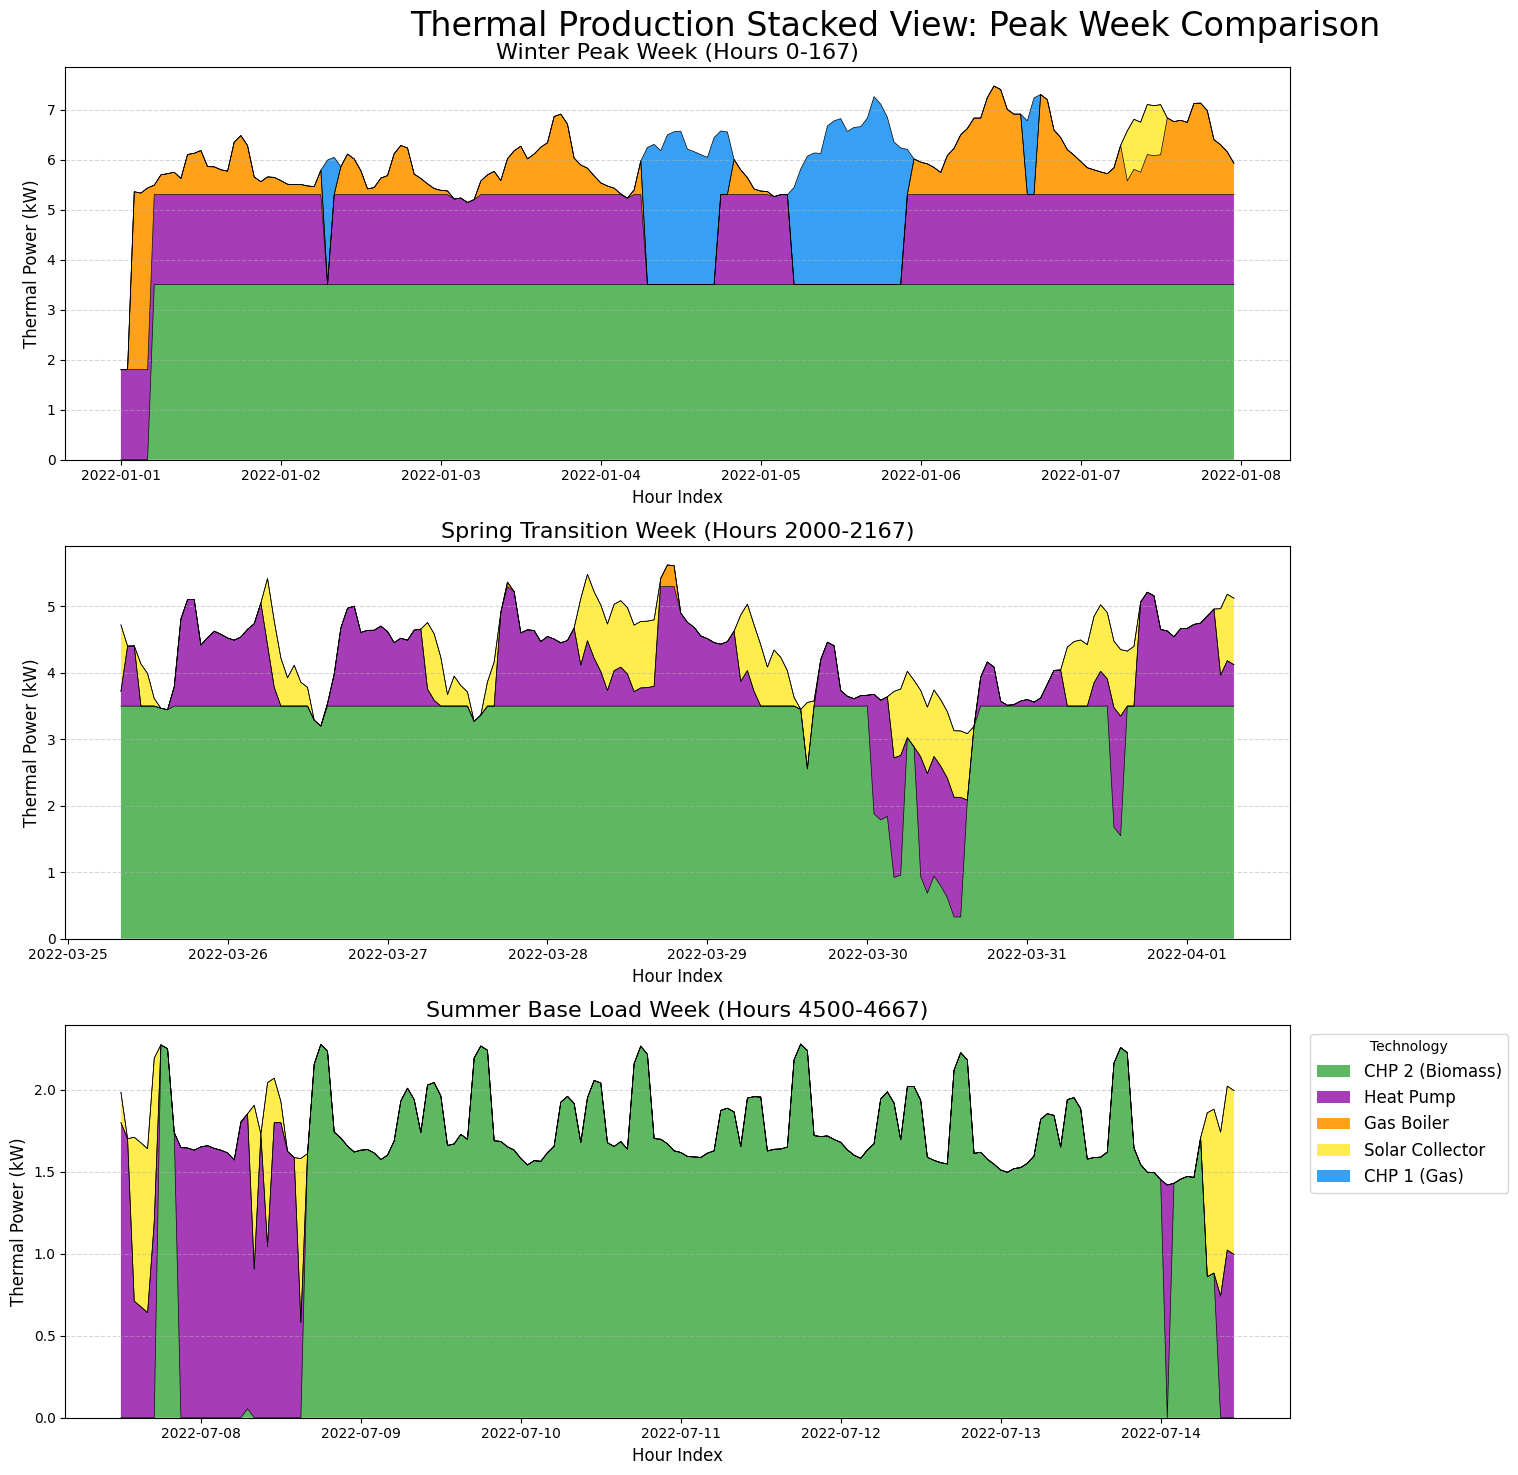


--- Summary of Thermal Production (MWh) ---
- CHP 2 (Biomass) (Color: #4CAF50): 24 MWh
- Heat Pump (Color: #9C27B0): 8 MWh
- Gas Boiler (Color: #FF9800): 3 MWh
- Solar Collector (Color: #FFEB3B): 1 MWh
- CHP 1 (Gas) (Color: #2196F3): 0 MWh

Sorting Order (Bottom of Stack to Top):
  5. CHP 1 (Gas)
  4. Solar Collector
  3. Gas Boiler
  2. Heat Pump
  1. CHP 2 (Biomass)


In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# --- ASSUMPTIONS ---
# We assume 'thermal_bus_node' is a dictionary containing the results from 
# views.node(results, "thermal_bus") with kW time series data.
# Component keys are assumed to be: 'chp_1', 'chp_2', 'gas_boiler_1', 'heat_pump', 'solar_collector'.

# 1. Define the components, their data keys, and preferred colors
component_data = {
    'CHP 1 (Gas)':         {'key': (('chp_1', 'thermal_bus'), 'flow'),          'color': '#2196F3'},  # Blue for Gas
    'CHP 2 (Biomass)':     {'key': (('chp_2', 'thermal_bus'), 'flow'),          'color': '#4CAF50'},  # Green for Biomass
    'Gas Boiler':          {'key': (('gas_boiler_1', 'thermal_bus'), 'flow'),   'color': '#FF9800'},  # Orange for Peak Gas Boiler
    'Heat Pump':           {'key': (('heat_pump', 'thermal_bus'), 'flow'),      'color': '#9C27B0'},  # Purple for HP
    'Solar Collector':     {'key': (('solar_collector', 'thermal_bus'), 'flow'), 'color': '#FFEB3B'},  # Yellow for Solar
}

# 2. Extract time series data and calculate annual sums
production_df = pd.DataFrame()
total_annual_production = {}

for name, data in component_data.items():
    # Retrieve the time series and ensure it's a pandas Series
    timeseries = thermal_bus_node["sequences"][data['key']]
    
    # Store the time series data (assumed in kW)
    production_df[name] = timeseries
    
    # Calculate the total annual energy (kWh), and store in MWh for display
    total_annual_production[name] = timeseries.sum() / 1000 # Sum (kW) = kWh, /1000 = MWh

# 3. Sort the components by total annual production (MWh) from LARGEST to SMALLEST
# The largest producer must be the first series in the list to form the base of the stack.
sorted_components = sorted(
    total_annual_production.items(), 
    key=lambda item: item[1], 
    reverse=True # TRUE places the LARGEST producer first (at the bottom of the stack)
)

# 4. Prepare data lists for stackplot in the sorted order
labels_sorted = [comp[0] for comp in sorted_components]
colors_sorted = [component_data[name]['color'] for name in labels_sorted]
series_sorted = [production_df[name] for name in labels_sorted]

# Calculate the total demand for the title comparison (in MWh)
Sum_th_demand_MWh = thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand'), 'flow')].sum() / 1000


# --- Plotting Function ---
def plot_stacked_production(ax, title, x_data, y_series, colors, labels):
    """Generates a single stacked area plot with boundaries."""
    
    # 1. Generate the Stacked Area Plot (filled areas)
    ax.stackplot(
        x_data,
        y_series,
        colors=colors,
        labels=labels,
        alpha=0.9
    )

    # 2. Add Clear Boundary Separation (draw lines on top of the stack)
    # Get the cumulative sum to plot the top line of each layer
    cumulative_sum = pd.Series([0] * len(x_data), index=x_data)
    for series in y_series:
        cumulative_sum += series
        # Plot the upper boundary of the current layer
        ax.plot(x_data, cumulative_sum, color='black', linewidth=0.5, alpha=1) 
    
    # Plot the bottom boundary (x-axis)
    ax.axhline(0, color='black', linewidth=0.5, alpha=1)
    
    # 3. Formatting
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Thermal Power (kW)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    
# --- FIGURE 1: ANNUAL THERMAL PRODUCTION STACKED AREA CHART ---
fig1, ax1 = plt.subplots(figsize=(18, 8))
fig1.suptitle('Annual Thermal Energy Production Mix and Contribution', fontsize=24)

# Plot the annual data
plot_stacked_production(
    ax1,
    title=f'Annual Production Stacked View (Total Demand: {Sum_th_demand_MWh:,.0f} MWh)',
    x_data=production_df.index,
    y_series=series_sorted,
    colors=colors_sorted,
    labels=labels_sorted
)

# Custom legend with MWh totals
legend_handles = []
custom_labels = []
for name in labels_sorted:
    mwh_sum = total_annual_production[name]
    custom_labels.append(f"{name}: {mwh_sum:,.0f} MWh")
    legend_handles.append(
        plt.Rectangle((0, 0), 1, 1, fc=component_data[name]['color'], alpha=0.9)
    )

ax1.legend(legend_handles, 
           custom_labels, 
           loc='upper left', 
           bbox_to_anchor=(1.01, 1), 
           title="Annual Production (MWh)",
           fontsize=12)

ax1.set_xlabel('Time (Hours of the Year)', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- FIGURE 2: PEAK WEEK COMPARISON (WINTER, SPRING, SUMMER) ---
fig2, axs2 = plt.subplots(3, 1, figsize=(18, 15), sharex=False)
fig2.suptitle('Thermal Production Stacked View: Peak Week Comparison', fontsize=24)

# Define peak week time slices (assuming 8760 hours/year)
# Note: The indices are pandas row indices, not necessarily the actual date time
time_slices = {
    'Winter Peak Week (Hours 0-167)':       (0, 168),      # Start of year (January)
    'Spring Transition Week (Hours 2000-2167)': (2000, 2168),  # Late March/Early April
    'Summer Base Load Week (Hours 4500-4667)':  (4500, 4668)   # Mid-July
}

for i, (period_title, (start, end)) in enumerate(time_slices.items()):
    ax = axs2[i]
    
    # Slice the data for the specific week
    sliced_series = [s.iloc[start:end] for s in series_sorted]
    sliced_x_data = production_df.index[start:end]
    
    plot_stacked_production(
        ax,
        title=period_title,
        x_data=sliced_x_data,
        y_series=sliced_series,
        colors=colors_sorted,
        labels=labels_sorted
    )
    ax.set_xlabel('Hour Index', fontsize=12) # Use index for simplicity

# Add legend to the bottom plot only
axs2[2].legend(legend_handles, 
               labels_sorted,
               loc='upper left', 
               bbox_to_anchor=(1.01, 1), 
               title="Technology",
               fontsize=12)
    
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# --- PRINT SUMMARY FOR CONTEXT ---
print("\n--- Summary of Thermal Production (MWh) ---")
for name, mwh in sorted(total_annual_production.items(), key=lambda item: item[1], reverse=True):
    print(f"- {name} (Color: {component_data[name]['color']}): {mwh:,.0f} MWh")

print(f"\nSorting Order (Bottom of Stack to Top):")
for i, name in enumerate(labels_sorted[::-1]):
    print(f"  {len(labels_sorted) - i}. {name}")

### Analyse storage node

No storage component found in the energy system. Skipping storage analysis.


KeyError: 'sequences'

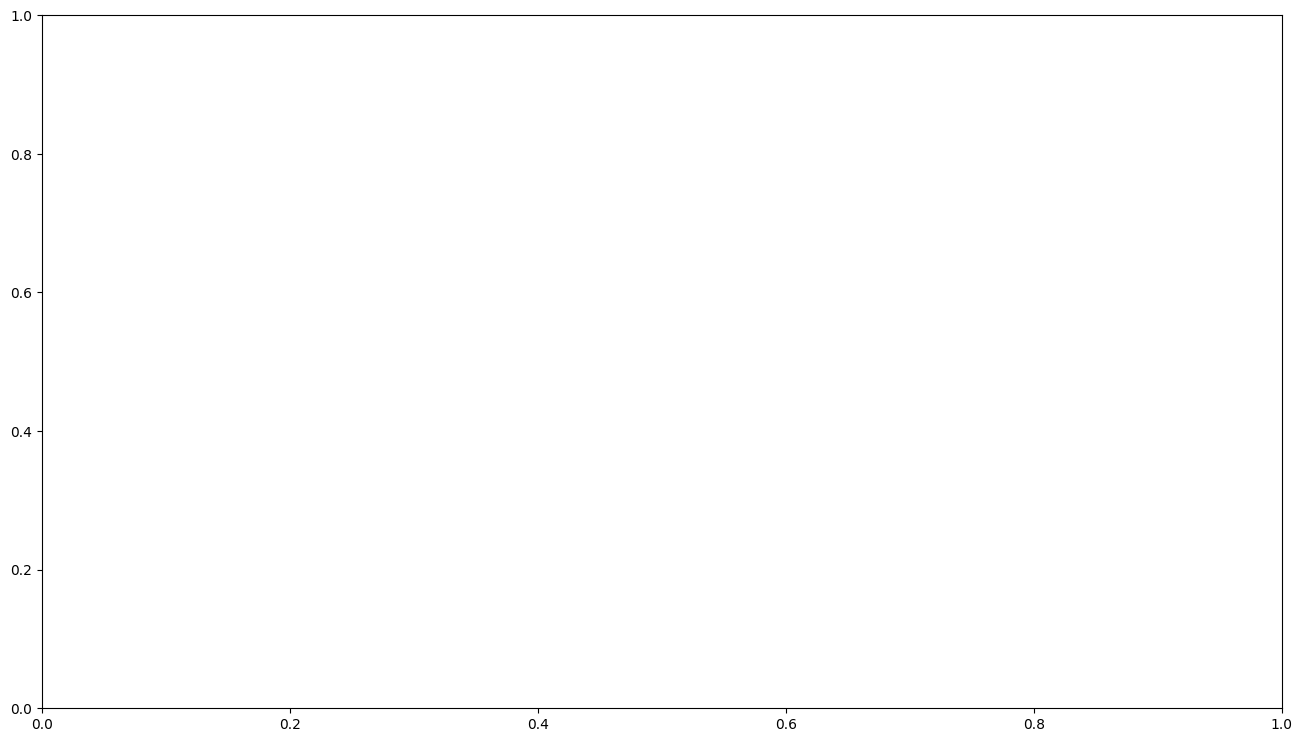

In [68]:
# Analyse storage node
# Check if storage exists in the energy system
if storage and 'sequences' in storage:
    Sum_storage_Outflow = storage['sequences'][(('storage', 'thermal_bus'), 'flow')].sum()
    Sum_storage_Inflow = storage['sequences'][(('thermal_bus', 'storage'), 'flow')].sum()
else:
    print("No storage component found in the energy system. Skipping storage analysis.")
    Sum_storage_Outflow = 0
    Sum_storage_Inflow = 0

fig, ax = plt.subplots(figsize=(16, 9))
storage['sequences'][(('thermal_bus', 'storage'), 'flow')].plot(
    ax=ax, kind="line", drawstyle="steps-post",color="green"
)
plt.legend(
    loc="upper right"
)
fig.subplots_adjust(top=0.8)
fig.suptitle(f'Storage inflow, Sum = {int(Sum_storage_Inflow / 1000)} MWh', fontsize=24)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 9))
storage['sequences'][(('storage', 'thermal_bus'), 'flow')].plot(
    ax=ax, kind="line", drawstyle="steps-post",color="blue"
)
plt.legend(
    loc="upper right"
)
fig.subplots_adjust(top=0.8)
fig.suptitle(f'Storage outflow, Sum = {int(Sum_storage_Outflow / 1000)} MWh', fontsize=24)
plt.show()

fig, ax = plt.subplots(figsize=(16, 9))
storage['sequences'][(('storage', 'None'), 'storage_content')].plot(
    ax=ax, kind="line", drawstyle="steps-post",color="orange"
)
plt.legend(
    loc="upper right"
)
fig.subplots_adjust(top=0.8)
fig.suptitle('Storage content', fontsize=24)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(3,figsize=(16, 9))
fig.suptitle('Comparison of storage flows and content', fontsize=24)
axs[0].plot(storage['sequences'][(('thermal_bus', 'storage'), 'flow')], 'green')
axs[0].set_title(f'Storage inflow, Sum = {int(Sum_storage_Inflow / 1000)} MWh')
axs[1].plot(storage['sequences'][(('storage', 'thermal_bus'), 'flow')], 'blue')
axs[1].set_title(f'Storage outflow, Sum = {int(Sum_storage_Outflow / 1000)} MWh')
axs[2].plot(storage['sequences'][(('storage', 'None'), 'storage_content')], 'orange')
axs[2].set_title('Storage content')

axs[0].set_ylabel('Power in kW')
axs[1].set_ylabel('Power in kW')
axs[2].set_ylabel('Content in kWh')

plt.tight_layout()
plt.show()

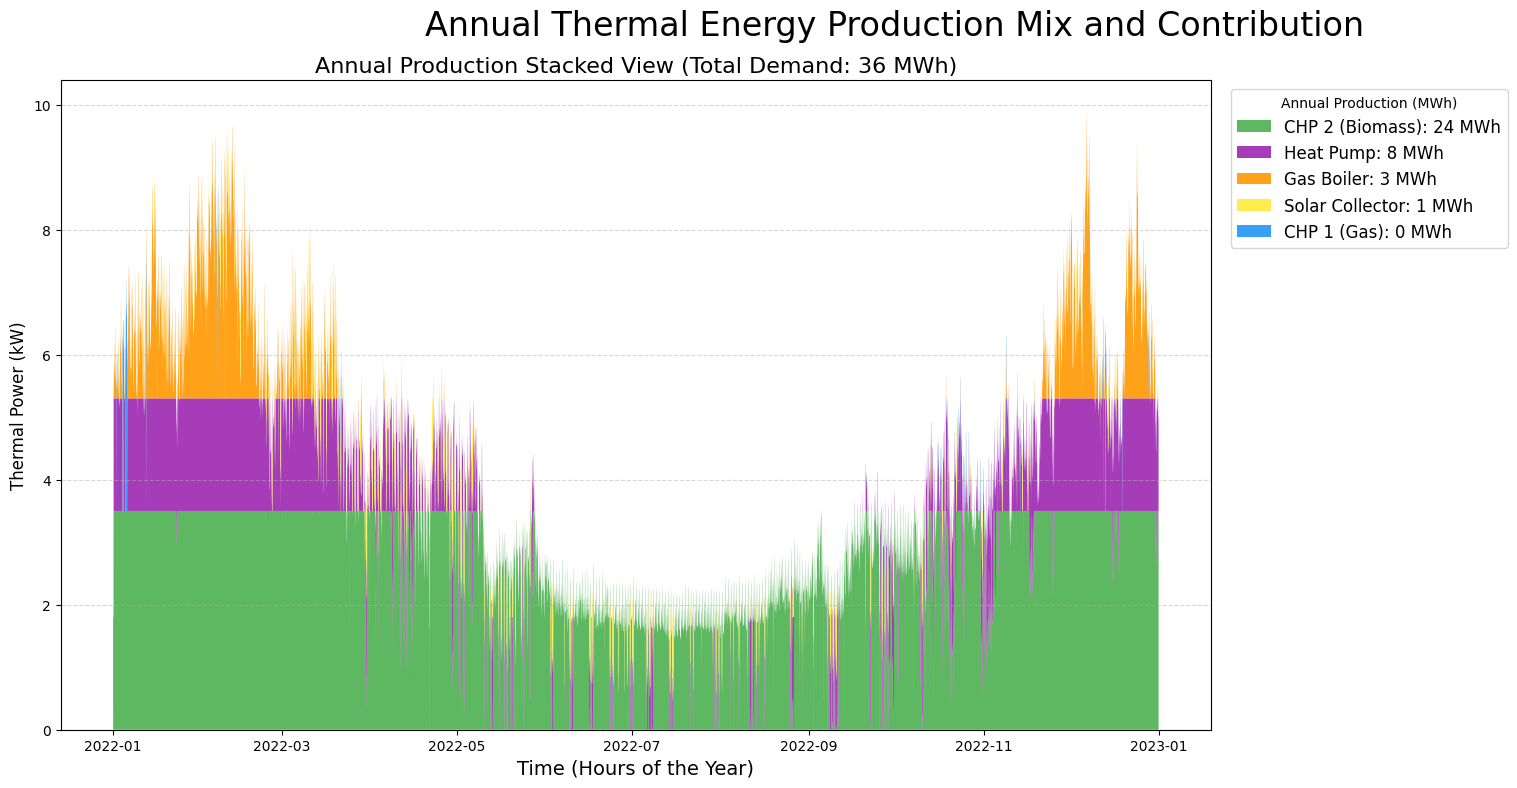

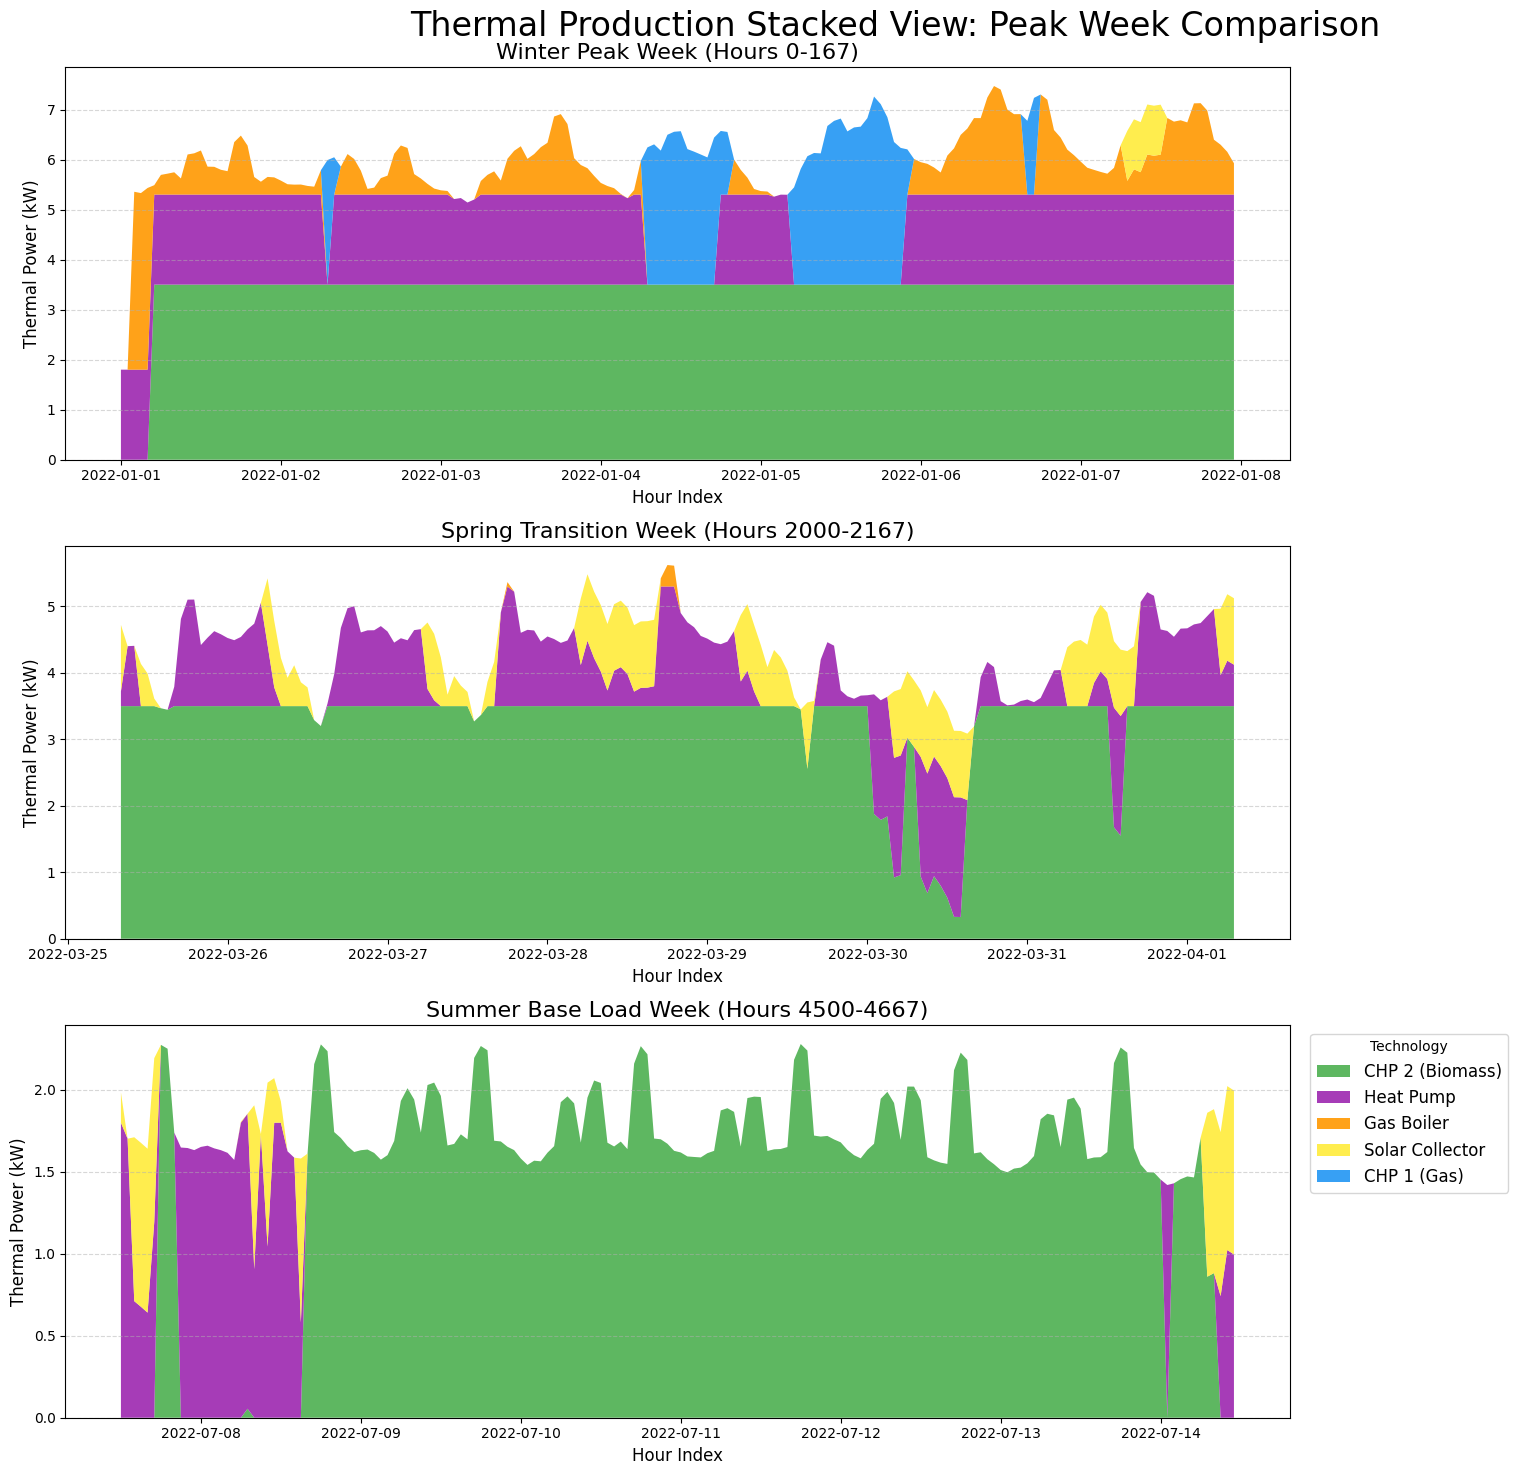


--- Summary of Thermal Production (MWh) ---
- CHP 2 (Biomass) (Color: #4CAF50): 24 MWh
- Heat Pump (Color: #9C27B0): 8 MWh
- Gas Boiler (Color: #FF9800): 3 MWh
- Solar Collector (Color: #FFEB3B): 1 MWh
- CHP 1 (Gas) (Color: #2196F3): 0 MWh

Sorting Order (Bottom of Stack to Top):
  5. CHP 1 (Gas)
  4. Solar Collector
  3. Gas Boiler
  2. Heat Pump
  1. CHP 2 (Biomass)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- ASSUMPTIONS ---
# We assume 'thermal_bus_node' is a dictionary containing the results from 
# views.node(results, "thermal_bus") with kW time series data.
# Component keys are assumed to be: 'chp_1', 'chp_2', 'gas_boiler_1', 'heat_pump', 'solar_collector'.

# 1. Define the components, their data keys, and preferred colors
component_data = {
    'CHP 1 (Gas)':         {'key': (('chp_1', 'thermal_bus'), 'flow'),          'color': '#2196F3'},  # Blue for Gas
    'CHP 2 (Biomass)':     {'key': (('chp_2', 'thermal_bus'), 'flow'),          'color': '#4CAF50'},  # Green for Biomass
    'Gas Boiler':          {'key': (('gas_boiler_1', 'thermal_bus'), 'flow'),   'color': '#FF9800'},  # Orange for Peak Gas Boiler
    'Heat Pump':           {'key': (('heat_pump', 'thermal_bus'), 'flow'),      'color': '#9C27B0'},  # Purple for HP
    'Solar Collector':     {'key': (('solar_collector', 'thermal_bus'), 'flow'), 'color': '#FFEB3B'},  # Yellow for Solar
}

# 2. Extract time series data and calculate annual sums
production_df = pd.DataFrame()
total_annual_production = {}

for name, data in component_data.items():
    # Retrieve the time series and ensure it's a pandas Series
    timeseries = thermal_bus_node["sequences"][data['key']]
    
    # Store the time series data (assumed in kW)
    production_df[name] = timeseries
    
    # Calculate the total annual energy (kWh), and store in MWh for display
    total_annual_production[name] = timeseries.sum() / 1000 # Sum (kW) = kWh, /1000 = MWh

# 3. Sort the components by total annual production (MWh) from LARGEST to SMALLEST
# The largest producer must be the first series in the list to form the base of the stack.
sorted_components = sorted(
    total_annual_production.items(), 
    key=lambda item: item[1], 
    reverse=True # TRUE places the LARGEST producer first (at the bottom of the stack)
)

# 4. Prepare data lists for stackplot in the sorted order
labels_sorted = [comp[0] for comp in sorted_components]
colors_sorted = [component_data[name]['color'] for name in labels_sorted]
series_sorted = [production_df[name] for name in labels_sorted]

# Calculate the total demand for the title comparison (in MWh)
Sum_th_demand_MWh = thermal_bus_node["sequences"][(('thermal_bus', 'thermal_demand'), 'flow')].sum() / 1000


# --- Plotting Function ---
def plot_stacked_production(ax, title, x_data, y_series, colors, labels):
    """Generates a single stacked area plot with boundaries."""
    
    # 1. Generate the Stacked Area Plot (filled areas)
    ax.stackplot(
        x_data,
        y_series,
        colors=colors,
        labels=labels,
        alpha=0.9
    )

    # 2. Add Clear Boundary Separation (draw lines on top of the stack)
    # Get the cumulative sum to plot the top line of each layer
    cumulative_sum = pd.Series([0] * len(x_data), index=x_data)
    for series in y_series:
        cumulative_sum += series
        # Plot the upper boundary of the current layer
        #ax.plot(x_data, cumulative_sum, color='black', linewidth=0.5, alpha=1) 
    
    # Plot the bottom boundary (x-axis)
    ax.axhline(0, color='black', linewidth=0.5, alpha=1)
    
    # 3. Formatting
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Thermal Power (kW)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    
# --- FIGURE 1: ANNUAL THERMAL PRODUCTION STACKED AREA CHART ---
fig1, ax1 = plt.subplots(figsize=(18, 8))
fig1.suptitle('Annual Thermal Energy Production Mix and Contribution', fontsize=24)

# Plot the annual data
plot_stacked_production(
    ax1,
    title=f'Annual Production Stacked View (Total Demand: {Sum_th_demand_MWh:,.0f} MWh)',
    x_data=production_df.index,
    y_series=series_sorted,
    colors=colors_sorted,
    labels=labels_sorted
)

# Custom legend with MWh totals
legend_handles = []
custom_labels = []
for name in labels_sorted:
    mwh_sum = total_annual_production[name]
    custom_labels.append(f"{name}: {mwh_sum:,.0f} MWh")
    legend_handles.append(
        plt.Rectangle((0, 0), 1, 1, fc=component_data[name]['color'], alpha=0.9)
    )

ax1.legend(legend_handles, 
           custom_labels, 
           loc='upper left', 
           bbox_to_anchor=(1.01, 1), 
           title="Annual Production (MWh)",
           fontsize=12)

ax1.set_xlabel('Time (Hours of the Year)', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- FIGURE 2: PEAK WEEK COMPARISON (WINTER, SPRING, SUMMER) ---
fig2, axs2 = plt.subplots(3, 1, figsize=(18, 15), sharex=False)
fig2.suptitle('Thermal Production Stacked View: Peak Week Comparison', fontsize=24)

# Define peak week time slices (assuming 8760 hours/year)
# Note: The indices are pandas row indices, not necessarily the actual date time
time_slices = {
    'Winter Peak Week (Hours 0-167)':       (0, 168),      # Start of year (January)
    'Spring Transition Week (Hours 2000-2167)': (2000, 2168),  # Late March/Early April
    'Summer Base Load Week (Hours 4500-4667)':  (4500, 4668)   # Mid-July
}

for i, (period_title, (start, end)) in enumerate(time_slices.items()):
    ax = axs2[i]
    
    # Slice the data for the specific week
    sliced_series = [s.iloc[start:end] for s in series_sorted]
    sliced_x_data = production_df.index[start:end]
    
    plot_stacked_production(
        ax,
        title=period_title,
        x_data=sliced_x_data,
        y_series=sliced_series,
        colors=colors_sorted,
        labels=labels_sorted
    )
    ax.set_xlabel('Hour Index', fontsize=12) # Use index for simplicity

# Add legend to the bottom plot only
axs2[2].legend(legend_handles, 
               labels_sorted,
               loc='upper left', 
               bbox_to_anchor=(1.01, 1), 
               title="Technology",
               fontsize=12)
    
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# --- PRINT SUMMARY FOR CONTEXT ---
print("\n--- Summary of Thermal Production (MWh) ---")
for name, mwh in sorted(total_annual_production.items(), key=lambda item: item[1], reverse=True):
    print(f"- {name} (Color: {component_data[name]['color']}): {mwh:,.0f} MWh")

print(f"\nSorting Order (Bottom of Stack to Top):")
for i, name in enumerate(labels_sorted[::-1]):
    print(f"  {len(labels_sorted) - i}. {name}")